In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice
pd.options.display.max_columns = 100

import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit
from scipy.sparse import csr_matrix
import re
import matplotlib.pyplot as plt

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb#, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

### Read this again

I need to take full advantage of the indexing before i start bulding stuff outside of it. Reread this to understand how he's doing a dict of multiple cols or whatev. Its multi asset. https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be



In [85]:
def reduce_pred_bt(df,size):
    idx = pd.IndexSlice
    rand_symbols = np.random.choice(df[~df['contract_symbol'].isnull()]['s_hx_symbol'].unique(),size=size,replace=False)
    rand_contract_symbols = df[(~df['contract_symbol'].isnull())&(df['s_hx_symbol'].isin(rand_symbols))]['contract_symbol']
    df = df.loc[idx[:,rand_contract_symbols],:]
    print(f"{df.shape}")
    return df

# df = reduce_pred_bt(df,100)

def parse_contract_symbol(cs):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"
    if isinstance(cs,str):
        cs = cs
    else:
        if isinstance(cs['contract_symbol'],str):
            cs = cs['contract_symbol']
        else:
            return {
                "option_expiration": np.nan,
                "symbol": np.nan,
                "root": np.nan,
                "strike": np.nan,
                "type": np.nan,
            }            
        
    
    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

def reduce_to_placeable_trades(df,discount=1.0):
    idx = pd.IndexSlice
    rand_symbols = np.random.choice(df[~df['contract_symbol'].isnull()]['s_hx_symbol'].unique(),size=size,replace=False)
    rand_contract_symbols = df[(~df['contract_symbol'].isnull())&(df['s_hx_symbol'].isin(rand_symbols))]['contract_symbol']
    df = df.loc[idx[:,rand_contract_symbols],:]
    print(f"{df.shape}")
    return df

In [83]:
# reduce_pred_bt(df,50).to_csv("/Users/xbno/Downloads/20210201_pred_bt_full_version_17_18_ex_sm.csv")
# df = reduce_pred_bt(df,250)
# df.to_csv("/Users/xbno/Downloads/20210201_pred_bt_full_version_17_18_sm.csv")

# df = pd.read_csv('/Users/xbno/Downloads/20210101_pred_bt_full_version_64.csv')
# df = pd.read_csv('/Users/xbno/Downloads/20210201_pred_bt_full_version_17_18.csv')
# df = pd.read_csv('/Users/xbno/Downloads/20210201_pred_bt_full_version_17_18_sm.csv') # 250
df = pd.read_csv('/Users/xbno/Downloads/20210201_pred_bt_full_version_17_18_ex_sm.csv') # 50
df['oc_hx_date'] = pd.to_datetime(df['oc_hx_date'])
df['s_hx_date'] = pd.to_datetime(df['s_hx_date'])
df.set_index(["oc_hx_date", "oc_hx_contract_symbol"], inplace=True)
df = df.sort_index()
df.shape

df = df.rename({'oc_hx_hi_bff': 'oc_hx_hi',
 'oc_hx_lo_bff': 'oc_hx_lo',
 'oc_hx_open_bff': 'oc_hx_open',
 'oc_hx_close_bff': 'oc_hx_close',
 'oc_hx_volume_bff': 'oc_hx_volume'},axis=1)

df[['option_expiration','symbol','root','strike','type']] = df.apply(parse_contract_symbol,axis=1,result_type="expand")

(146963, 19)

### Create entry/exit for vectorbt - Working with reduced symbols

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

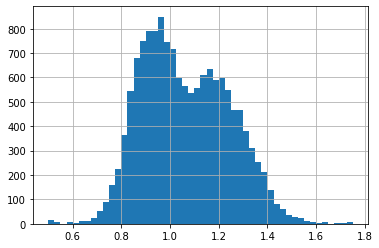

In [87]:
df['y_pred'].hist(bins=50)

In [26]:
# discount = 1.0
# thresh=1.5
# print(df[(df['trade_price']*discount >= df['lo_day_after_purch'])&(df['y_pred']>=thresh)].dropna(subset=['contract_symbol'])['win'].mean())
# df[(df['trade_price']*discount >= df['lo_day_after_purch'])&(df['y_pred']>=thresh)].dropna(subset=['contract_symbol'])#['win'].mean()

In [27]:
a = df.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
a = a.sort_index()
# a = a.groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].mean().unstack().dropna(how='all')
a = a.groupby(['oc_hx_date','oc_hx_contract_symbol'])['oc_hx_close'].mean().unstack().dropna(how='all')
a

oc_hx_contract_symbol,AHC1210618C00005000,AHC210219C00002500,AHC210319C00002500,AHC210416C00002500,AHC210521C00002500,ARAY210219C00006000,ARAY210319C00006000,ARAY210319P00005000,ARAY210416C00006000,ARAY210416P00004000,ARAY210416P00005000,ARAY210521C00005000,ARAY210521P00005000,ARAY210618C00005000,ARAY210716C00005000,ARW210319C00115000,ARW210319P00090000,ARW210319P00095000,ARW210521C00115000,ARW210521C00125000,ARW210521P00115000,ARW210618C00125000,ARW210618P00115000,AXS210319C00055000,AXS210416C00055000,AXS210521C00055000,AXS210521C00060000,AXS210521P00050000,AXS210618C00055000,AXS210716C00055000,AXS210820P00045000,AXS210820P00050000,BBAR210319C00003000,BBAR210416C00005000,BBAR210716C00005000,BBAR210716P00003000,BBDC210319P00010000,BBDC210416C00010000,BGFV210219C00015000,BGFV210219C00017500,BGFV210219C00020000,BGFV210219C00022500,BGFV210219P00012500,BGFV210319C00015000,BGFV210319C00017500,BGFV210319C00020000,BGFV210319P00012500,BGFV210319P00015000,BGFV210416C00015000,BGFV210416C00017500,...,ZTO210319P00035000,ZTO210319P00036000,ZTO210319P00037000,ZTO210416C00028000,ZTO210416C00029000,ZTO210416C00030000,ZTO210416C00031000,ZTO210416C00032000,ZTO210416C00033000,ZTO210416C00035000,ZTO210416C00037000,ZTO210416C00039000,ZTO210416C00040000,ZTO210416C00045000,ZTO210416P00024000,ZTO210416P00025000,ZTO210416P00026000,ZTO210416P00027000,ZTO210416P00031000,ZTO210416P00033000,ZTO210416P00034000,ZTO210416P00036000,ZTO210416P00037000,ZTO210521C00028000,ZTO210521C00029760,ZTO210521C00030000,ZTO210521C00030760,ZTO210521C00031000,ZTO210521C00031760,ZTO210521C00032000,ZTO210521C00033760,ZTO210521C00034000,ZTO210521C00034760,ZTO210521C00035760,ZTO210521C00036760,ZTO210521P00023760,ZTO210521P00025000,ZTO210521P00026000,ZTO210521P00027000,ZTO210521P00027760,ZTO210521P00028760,ZTO210521P00029760,ZTO210521P00030760,ZTO210521P00031760,ZTO210618C00031000,ZTO210618C00032000,ZTO210618C00035000,ZTO210618C00036000,ZTO210618P00030000,ZTO210618P00032000
oc_hx_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-01,NaN,0.30,NaN,NaN,0.65,0.05,NaN,0.50,NaN,NaN,NaN,NaN,NaN,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,0.15,NaN,0.15,NaN,NaN,NaN,1.01,0.45,0.30,0.16,0.60,2.17,1.39,0.95,1.40,NaN,2.50,1.81,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3.50,2.60,NaN,NaN,1.06,NaN,NaN,NaN,NaN,NaN,NaN,2.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-02,NaN,0.33,0.46,NaN,0.65,0.05,0.20,0.48,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.25,0.05,0.12,0.75,NaN,NaN,0.90,0.33,0.15,0.10,0.57,1.99,1.45,0.85,1.53,NaN,2.35,1.60,...,NaN,NaN,NaN,7.0,7.0,6.30,NaN,4.37,4.00,3.05,NaN,1.55,1.10,NaN,NaN,NaN,NaN,NaN,NaN,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-03,NaN,0.45,0.75,NaN,0.75,0.10,0.25,0.40,NaN,NaN,NaN,NaN,NaN,1.05,NaN,NaN,NaN,2.88,NaN,NaN,NaN,NaN,NaN,0.32,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.25,0.05,0.05,0.67,NaN,NaN,0.80,0.34,0.16,0.11,0.45,2.00,1.30,0.85,1.40,NaN,2.35,1.57,...,NaN,NaN,NaN,7.0,1.5,6.52,NaN,3.98,4.40,3.26,NaN,1.55,0.94,NaN,0.17,NaN,NaN,0.32,NaN,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-04,NaN,0.38,0.55,NaN,0.70,0.10,0.21,0.35,NaN,NaN,NaN,NaN,NaN,0.90,NaN,NaN,NaN,1.30,NaN,NaN,NaN,NaN,NaN,0.43,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,0.25,0.05,0.05,0.67,NaN,NaN,1.04,0.32,0.10,0.10,0.35,2.29,1.45,0.85,1.30,2.50,2.70,1.80,...,NaN,NaN,NaN,7.0,1.5,6.52,NaN,3.98,3.38,2.50,NaN,1.55,0.94,0.4,0.17,NaN,NaN,0.25,NaN,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-05,NaN,0.38,0.52,NaN,0.70,0.10,0.25,0.35,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,1.30,NaN,NaN,NaN,NaN,NaN,0.45,NaN,NaN,NaN,NaN,1.90,NaN,NaN,NaN,0

In [29]:
a['AHC1210618C00005000'].dropna()

oc_hx_date
2021-06-15    0.20
2021-06-16    0.05
2021-06-17    0.05
2021-06-18    0.05
Name: AHC1210618C00005000, dtype: float64

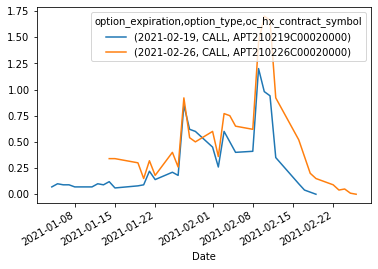

In [59]:
# a.loc[:,idx['APRN','2021-05-21','CALL','oc_hx_open','APRN210521C00007000']]
# df_tmp.loc[:,idx['APT']].plot()

In [ ]:
ohlcv

In [164]:
oc_cols = ['oc_hx_open','oc_hx_hi','oc_hx_lo','oc_hx_close']
s_cols = ["s_hx_close"]


df_tmp = df.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
df_tmp = df_tmp.sort_index()
df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])[cols].max().unstack().dropna(how='all')
df_tmp.index.name = 'Date'
df_tmp.columns.names = ['oc_hx','oc_hx_contract_symbol']
df_tmp.columns = df_tmp.columns.swaplevel(0,1)

df_close = df_tmp.copy()
df_close.loc[:,:] = 1.0

for option_duration in option_durations:
    if option_duration["option_expiration"] in df_close.index:
        if option_duration["type"] == "CALL":
            if df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],"s_hx_close"]] > option_duration["strike"]:
                continue
            else:
                df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0
        elif option_duration["type"] == "PUT":
            if df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],"s_hx_close"]] < option_duration["strike"]:
                continue
            else:
                df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0
        
# df_close.loc[:"2021-03-19",idx[:,"AXS210319C00055000"]]
# df_tmp.loc[:"2021-03-19",idx[:,"AXS210319C00055000"]]
        
df_tmp = (df_tmp*df_close).replace({0.0:0.00001})

In [168]:
multi_ind = list(zip(
            [parse_contract_symbol(c)['symbol'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')],
            [parse_contract_symbol(c)['option_expiration'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')],
            [parse_contract_symbol(c)['type'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')]
        ))
df_tmp = df_tmp.vbt.stack_index(pd.MultiIndex.from_tuples(multi_ind, names=["symbol", "option_expiration", "option_type"]))
df_tmp

In [177]:
df.head()

contract_symbol  y_pred purch_date  \
oc_hx_date oc_hx_contract_symbol                                      
2021-02-01 AHC210219C00002500                NaN     NaN        NaN   
           AHC210521C00002500                NaN     NaN        NaN   
           ARAY210219C00006000               NaN     NaN        NaN   
           ARAY210319P00005000               NaN     NaN        NaN   
           ARAY210618C00005000               NaN     NaN        NaN   

                                 purch_datetime  trade_price  \
oc_hx_date oc_hx_contract_symbol                               
2021-02-01 AHC210219C00002500               NaN          NaN   
           AHC210521C00002500               NaN          NaN   
           ARAY210219C00006000              NaN          NaN   
           ARAY210319P00005000              NaN          NaN   
           ARAY210618C00005000              NaN          NaN   

                                 option_expiration oc_hx_symbol  oc_hx_hi  \
oc_hx_date oc_hx_contract_symbol                                            
2021-02-01 AHC210219C00002500                  NaN          AHC      0.42   
           AHC210521C00002500                  NaN          AHC      0.65   
           ARAY210219C00006000                 NaN         ARAY      0.10   
           ARAY210319P00005000                 NaN         ARAY      0.50   
           ARAY210618C00005000                 NaN         ARAY      0.85   

                                  oc_hx_lo  oc_hx_open  oc_hx_close  \
oc_hx_date oc_hx_contract_symbol                                      
2021-02-01 AHC210219C00002500         0.30        0.40         0.30   
           AHC210521C00002500         0.60        0.60         0.65   
           ARAY210219C00006000        0.05        0.06         0.05   
           ARAY210319P00005000        0.50        0.50         0.50   
           ARAY210618C00005000        0.85        0.85         0.85   

                                  oc_hx_volume s_hx_symbol  s_hx_hi  s_hx_lo  \
oc_hx_date oc_hx_contract_symbol                                               
2021-02-01 AHC210219C00002500               18         AHC     8.76   8.4800   
           AHC210521C00002500                3         AHC     8.76   8.4800   
           ARAY210219C00006000              16        ARAY     5.05   4.8601   
           ARAY210319P00005000               5        ARAY     5.05   4.8601   
           ARAY210618C00005000               3        ARAY     5.05   4.8601   

                                  s_hx_open  s_hx_close  s_hx_volume  \
oc_hx_date oc_hx_contract_symbol                                       
2021-02-01 AHC210219C00002500          8.60        8.68      21416.0   
           AHC210521C00002500          8.60        8.68      21416.0   
           ARAY210219C00006000         5.02        4.93     932985.0   
           ARAY210319P00005000         5.02        4.93     932985.0   
           ARAY210618C00005000         5.02        4.93     932985.0   

                                  s_hx_date symbol root  strike type  
oc_hx_date oc_hx_contract_symbol                                      
2021-02-01 AHC210219C00002500    2021-02-01    NaN  NaN     NaN  NaN  
           AHC210521C00002500    2021-02-01    NaN  NaN     NaN  NaN  
           ARAY210219C00006000   2021-02-01    NaN  NaN     NaN  NaN  
           ARAY210319P00005000   2021-02-01    NaN  NaN     NaN  NaN  
           ARAY210618C00005000   2021-02-01    NaN  NaN     NaN  NaN

In [180]:
oc_pred_details = df[['contract_symbol','option_expiration',"strike","type","y_pred","purch_date"]].drop_duplicates().dropna().to_dict('records')

In [181]:
def convert_to_wide(df,oc_pred_details,oc_cols,s_cols,otm_exp_price=0.00001):
    cols = oc_cols + s_cols
    df_tmp = df.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
    df_tmp = df_tmp.sort_index()
    df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])[cols].max().unstack().dropna(how='all')
    df_tmp.index.name = 'Date'
    df_tmp.columns.names = ['oc_hx','oc_hx_contract_symbol']
    df_tmp.columns = df_tmp.columns.swaplevel(0,1)
    
    df_close = df_tmp.copy()
    df_close.loc[:,:] = 1.0
#     option_durations = df[['contract_symbol','option_expiration',"strike","type"]].drop_duplicates().dropna().to_dict('records')
#     for option_duration in option_durations:
    for option_duration in oc_pred_details:
        if option_duration["option_expiration"] in df_close.index:
            if option_duration["type"] == "CALL":
                if df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],"s_hx_close"]] > option_duration["strike"]:
                    continue
                else:
                    df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0
            elif option_duration["type"] == "PUT":
                if df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],"s_hx_close"]] < option_duration["strike"]:
                    continue
                else:
                    df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0

    df_tmp = (df_tmp*df_close).replace({0.0:otm_exp_price})
    
    multi_ind = list(zip(
            [parse_contract_symbol(c)['symbol'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')],
            [parse_contract_symbol(c)['option_expiration'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')],
            [parse_contract_symbol(c)['type'] for c in df_tmp.columns.get_level_values('oc_hx_contract_symbol')]
        ))
    df_tmp = df_tmp.vbt.stack_index(pd.MultiIndex.from_tuples(multi_ind, names=["symbol", "option_expiration", "option_type"]))
    return df_tmp

In [182]:
df_tmp = convert_to_wide(df,oc_pred_details,oc_cols=['oc_hx_open','oc_hx_hi','oc_hx_lo','oc_hx_close'],s_cols=["s_hx_close"])

In [184]:
def uniform_pred_thresh_entry(df_tmp,thresh=0,reduce=False):
    entry_df = df_tmp.copy()
    entry_df.loc[:,:] = 0.0
    for option_duration in oc_pred_details:
        if option_duration["option_expiration"] in entry_df.index:
            if option_duration["y_pred"] >= thresh:
                entry_df.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0
                continue
                else:
                    
            elif option_duration["type"] == "PUT":
                if df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],"s_hx_close"]] < option_duration["strike"]:
                    continue
                else:
                    df_close.loc[option_duration['option_expiration'],idx[option_duration['contract_symbol'],oc_cols]] = 0.0

SyntaxError: invalid syntax (<ipython-input-184-f9fbdd2a1323>, line 9)

I can optimize this by reducing the entry_df size down to only contract_symbols that have trades, since I'm only keeping thresholded trades.. would need to reduce df at the same time.

In [173]:
def uniform_pred_thresh_entry(df,thresh=0,reduce=False):
    """Create entries from simple y_pred >= thresh criteria"""
    idx = pd.IndexSlice
    if reduce == False:
        entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].last().unstack() > thresh
        entry_df = entry_df.shift(1)
        entry_df = entry_df.fillna(False)
        print(f"df:{df.shape}, entry_df:{entry_df.shape}")
        return df, entry_df
    else:
        entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].last().unstack() > thresh
        entry_df = entry_df.shift(1)
        entry_df = entry_df.fillna(False)
        entry_df = entry_df.loc[:,entry_df.astype(int).sum(axis=0)!=0]
        df = df.loc[idx[:,entry_df.columns],:]
        print(f"df:{df.shape}, entry_df:{entry_df.shape}")
        return df, entry_df

def expiration_exit(entry_df):
    """Create exits from simple exit on expiration"""
    exp_exit_df = entry_df.copy()
    exp_exit_df.iloc[:,:] = False

    tmp_df = entry_df.sum()[entry_df.sum()!=0].reset_index()
    tmp_df = tmp_df.rename(columns={'oc_hx_contract_symbol':'contract_symbol'})
    tmp_df[['option_expiration','symbol','root','strike','type']] = tmp_df.apply(parse_contract_symbol,axis=1,result_type="expand")
    exits = tmp_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

    for exit in exits:
        exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True
    return exp_exit_df

In [174]:
uniform_pred_thresh_entry(df,thresh=1.5,reduce=False)[0]

df:(146963, 23), entry_df:(104, 4825)


contract_symbol  y_pred purch_date  \
oc_hx_date oc_hx_contract_symbol                                      
2021-02-01 AHC210219C00002500                NaN     NaN        NaN   
           AHC210521C00002500                NaN     NaN        NaN   
           ARAY210219C00006000               NaN     NaN        NaN   
           ARAY210319P00005000               NaN     NaN        NaN   
           ARAY210618C00005000               NaN     NaN        NaN   
...                                          ...     ...        ...   
2021-06-29 MARK210716C00003000               NaN     NaN        NaN   
           MARK210716C00003500               NaN     NaN        NaN   
           MARK210716P00001500               NaN     NaN        NaN   
           MARK210820C00002500               NaN     NaN        NaN   
           MARK210820C00004000               NaN     NaN        NaN   

                                 purch_datetime  trade_price  \
oc_hx_date oc_hx_contract_symbol                               
2021-02-01 AHC210219C00002500               NaN          NaN   
           AHC210521C00002500               NaN          NaN   
           ARAY210219C00006000              NaN          NaN   
           ARAY210319P00005000              NaN          NaN   
           ARAY210618C00005000              NaN          NaN   
...                                         ...          ...   
2021-06-29 MARK210716C00003000              NaN          NaN   
           MARK210716C00003500              NaN          NaN   
           MARK210716P00001500              NaN          NaN   
           MARK210820C00002500              NaN          NaN   
           MARK210820C00004000              NaN          NaN   

                                 option_expiration oc_hx_symbol  oc_hx_hi  \
oc_hx_date oc_hx_contract_symbol                                            
2021-02-01 AHC210219C00002500                  NaN          AHC      0.42   
           AHC210521C00002500                  NaN          AHC      0.65   
           ARAY210219C00006000                 NaN         ARAY      0.10   
           ARAY210319P00005000                 NaN         ARAY      0.50   
           ARAY210618C00005000                 NaN         ARAY      0.85   
...                                            ...          ...       ...   
2021-06-29 MARK210716C00003000                 NaN         MARK      0.05   
           MARK210716C00003500                 NaN         MARK      0.05   
           MARK210716P00001500                 NaN         MARK      0.05   
           MARK210820C00002500                 NaN         MARK      0.20   
           MARK210820C00004000                 NaN         MARK      0.07   

                                  oc_hx_lo  oc_hx_open  oc_hx_close  \
oc_hx_date oc_hx_contract_symbol                                      
2021-02-01 AHC210219C00002500         0.30        0.40         0.30   
           AHC210521C00002500         0.60        0.60         0.65   
           ARAY210219C00006000        0.05        0.06         0.05   
           ARAY210319P00005000        0.50        0.50         0.50   
           ARAY210618C00005000        0.85        0.85         0.85   
...                                    ...         ...          ...   
2021-06-29 MARK210716C00003000        0.04        0.04         0.05   
           MARK210716C00003500        0.05        0.05         0.05   
           MARK210716P00001500        0.02        0.02         0.05   
           MARK210820C00002500        0.20        0.20         0.20   
           MARK210820C00004000        0.05        0.05         0.07   

                                  oc_hx_volume s_hx_symbol  s_hx_hi  s_hx_lo  \
oc_hx_date oc_hx_contract_symbol                                               
2021-02-01 AHC210219C00002500               18         AHC    8.760   8.4800   
           AHC210521C00002500                3         AHC    8.760   8.4800   
           ARAY210219C00006000

In [69]:
df_reduced, entry_df = uniform_pred_thresh_entry(df,thresh=1.5,reduce=True)
option_durations = df_reduced[['contract_symbol','option_expiration',"strike","type"]].drop_duplicates().dropna().to_dict('records')
# df_tmp = convert_to_wide(df_reduced,'oc_hx_open')
# exp_exit_df = expiration_exit(entry_df)

df:(4236, 23), entry_df:(104, 77)


In [46]:
# df_reduced
df_reduced.loc[idx['2021-07-19',:]]

,,contract_symbol,y_pred,purch_date,purch_datetime,trade_price,option_expiration,oc_hx_symbol,oc_hx_hi,oc_hx_lo,oc_hx_open,oc_hx_close,oc_hx_volume,s_hx_symbol,s_hx_hi,s_hx_lo,s_hx_open,s_hx_close,s_hx_volume,s_hx_date,symbol,root,strike,type
oc_hx_date,oc_hx_contract_symbol,,,,,,,,,,,,,,,,,,,,,,,


In [44]:
convert_to_wide(df_reduced,'oc_hx_open',option_durations)

KeyError: '2021-07-16'

In [52]:
def pct_inc_exit(df_tmp,entry_df,thresh=1):
    entry_price_df = (entry_df*df_tmp).replace(0,np.nan).ffill()
    pct_inc_df = (df_tmp - entry_price_df) / entry_price_df
    
    

In [190]:
def pct_inc_exit(df_tmp,entry_df,thresh=1):
    pct_exit_df = entry_df.copy()
    pct_exit_df.iloc[:,:] = False
    
    entry_price_df = (entry_df*df_tmp).replace(0,np.nan).ffill()
    pct_inc_df = (df_tmp - entry_price_df) / entry_price_df
    
    r,c = np.where(pct_inc_df>thresh)
    b = pd.DataFrame(np.column_stack((pct_inc_df.index[r],pct_inc_df.columns[c],pct_inc_df.values[r,c])))
    b[0] = pd.to_datetime(b[0])
    b = b.drop_duplicates(subset=[1],keep='first')
    
    for k,v in b.set_index(1)[0].to_dict().items():
        pct_exit_df.loc[v,k] = True
    return pct_exit_df

In [191]:
pct_exit_df = pct_inc_exit(df_tmp,entry_df,thresh=0.5)

**DO THIS** 

Work on setting up the exit stat where you exit everything when the value is gt X pct. should probably look into documentation since there were rolling window type things like this. i think he structured his frames completely differently, including all relevant info within the df_tmp itself to dynamically change on the fly instead of hardcoding the exit prior to running

In [192]:
cs = 'MVIS210219C00016000'
# entry_price_df.loc[:,idx[:,:,:,cs]].dropna()
# df_tmp.loc[:,idx[:,:,:,cs]].dropna()
# pct_inc_df.loc[:,idx[:,:,:,cs]].dropna()
pct_exit_df.loc[:,idx[:,:,:,cs]].replace({False:np.nan}).dropna()

symbol,MVIS
option_expiration,2021-02-19
option_type,CALL
oc_hx_contract_symbol,MVIS210219C00016000
oc_hx_date,
2021-02-08,True


### Setup wide data for vectorbt

One column per option_contract series

In [43]:
# exp_exit_df = entry_df.copy()
# exp_exit_df.iloc[:,:] = False

# entry_exit_df = df.dropna(subset=['contract_symbol'])
# entry_exit_df[['option_expiration','symbol','root','strike','type']] = entry_exit_df.apply(parse_contract_symbol,axis=1,result_type="expand")
# entry_exit_df = entry_exit_df[['contract_symbol','option_expiration','purch_date']].drop_duplicates()
# exits = entry_exit_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

# for exit in exits:
#     exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True

### Create multiple random exits

Compare random exits to the exiting at expiration

In [193]:
exit_df = exp_exit_df.copy()
exit_df.columns = df_tmp.columns
entry_df.columns = df_tmp.columns

rand_exit_types = [f'rand_{i}' for i in range(10)]
rand_exit_dfs = {}
for rand_exit_type in rand_exit_types:
    rand_exit_df = vbt.IRPROBEX.run(
        entry_df, 
        df_tmp,
    ).exits
    rand_exit_df.columns = entry_df.columns
    rand_exit_dfs[rand_exit_type] = rand_exit_df

# for r in rand_exit_types:
#     print(f"rand_exit_dfs['{r}'],")
    
exit_types = rand_exit_types + ['expiration'] + ['pct_inc']
all_exit_df = pd.DataFrame.vbt.concat(
    rand_exit_dfs['rand_0'],
    rand_exit_dfs['rand_1'],
    rand_exit_dfs['rand_2'],
    rand_exit_dfs['rand_3'],
    rand_exit_dfs['rand_4'],
    rand_exit_dfs['rand_5'],
    rand_exit_dfs['rand_6'],
    rand_exit_dfs['rand_7'],
    rand_exit_dfs['rand_8'],
    rand_exit_dfs['rand_9'],
    exp_exit_df,
    pct_exit_df,
    keys=pd.Index(exit_types, name='exit_type')
)

In [194]:
assert df_tmp.shape == entry_df.shape == exp_exit_df.shape
# assert df_tmp.columns == entry_df.columns == exp_exit_df.columns

### Show trades

This is excellent! Potentially figure out how to add this to a dashboard with a selector. 

Inspiration also here: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/PortfolioOptimization.ipynb Looks like there could be a much better way of indexing these.


### Dashboard inspiration
Probably will need to create a dashboard using dash components: https://github.com/facultyai/dash-bootstrap-components like this: https://github.com/polakowo/vectorbt/tree/master/apps/candlestick-patterns.

Example here: https://candlestick-patterns.herokuapp.com/

In [196]:
contract_symbol = df_tmp.columns[-1]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

contract_symbol = df_tmp.columns[-21]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.show()

In [855]:
# symbol = 'FEYE'
# option_expiration = '2021-01-08'
# option_type = 'Call'
# contract_symbols = [
#     c for c in df_tmp.columns 
#         if symbol in c 
#         and option_expiration in c
#         and option_type in c
# ]
# print(f"{len(contract_symbols)} Traces")
# contract_symbol = contract_symbols[0]
# fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
# fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
# fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

# for contract_symbol in contract_symbols[1:50]:
#     fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
#     fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
#     fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=800,)
# fig.show()

### Working with pd.MultiIndex

Slicing

In [1058]:
# find example to inspect
# entry_df.sum()[entry_df.sum()!=0]
# a = entry_df.loc(axis=1)[:,:,:,['AMC210305C00007000']]
# a[a].dropna()

# idx = pd.IndexSlice
# entry_df.loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: bool)

### Create vectorbt portfolio.from_orders()

Join entry_df and exit_df that had been created for the signals version to create +/- values for orders

In [214]:
# entry_sz = entry_df.astype(int) * 10 * 100
# exit_sz = exit_df.astype(int) * entry_sz.sum()
# entry_exit_sz = entry_sz - exit_sz

# # converts old pandas entry_exit_sz sparse version (didn't work as sparse, so unnecessary)
# row = []
# col = []
# data = []
# for i,r in enumerate(entry_exit_sz.index):
#     for j,c in enumerate(entry_exit_sz.columns):
#         if entry_exit_sz.loc[r,c] == 0:
#             continue
#         else:
#             row.append(i)
#             col.append(j)
#             data.append(entry_exit_sz.loc[r,c])

# col_size = j+1
# row_size = i+1

# # entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size)))  # doesnt' work
# entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size))).toarray()

In [27]:
# portfolio = vbt.Portfolio.from_orders(
# #     df_tmp,
#     price,
#     size=entry_exit_sz, 
#     min_size=0,
#     max_size=10000, 
# #     group_by=True,
# #     group_by=symbol_groups, 
#     log=True, 
#     fees=0.001, 
#     slippage=0.001,
# #     init_cash='auto',
#     init_cash='autoalign',
# #     cash_sharing=True, 
#     direction='longonly',
#     freq='1D',
# )

# portfolio.total_return()

# Brainstorming

### Entry logic
- Only buy at 1/2 price of original trade
- Buy X at orig price, Y at .75 * orig price, Z at .5 * orig price. Good til expired
- 

### Exit logic
- Set X% stop loss for Z% of shares, after Y% increase
    - Sell 1/2 of shares at 20% max drawdown, after hitting 50% increase
- Sell Z% of shares after Y% increase 
    - Sell all shares after 100% increase
    - Sell 1/2 shares after 100% increase and other 1/2 after 200% increase

### Create vectorbt portfolio.from_orders()

Create rand exiting to compare to expiration exiting. Inspired from: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/StopSignals.ipynb

The idea is that if I can create exit signals based on actual functions than I can actually beomce confident in which is the best/safest method overall.

- Entry signal same for all
- Exit signal random each time

In [197]:
def uniform_cash_order_sizing(df_tmp,entry_size_df,max_cash_per_trade=150,return_share_size=True):
    entry_contract_size_df = (max_cash_per_trade // (df_tmp * 100 * entry_size_df)).replace([np.inf, -np.inf], np.nan).fillna(0)
    if return_share_size:
        return entry_contract_size_df * 100
    else:
        return entry_contract_size_df

def uniform_quantity_order_sizing(df_tmp,entry_size_df,max_quantity_per_trade=10):
    return (max_quantity_per_trade * entry_size_df).replace([np.inf, -np.inf], np.nan).fillna(0)

uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),100).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]
uniform_quantity_order_sizing(df_tmp,entry_df.copy().astype(int),500).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: int64)

In [198]:
entry_size_df = uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),max_cash_per_trade)

In [199]:
entry_size_df

symbol                               ABNB                AYRO  \
option_expiration              2021-05-21          2021-04-16   
option_type                          CALL                CALL   
oc_hx_contract_symbol ABNB210521C00210000 AYRO210416C00007500   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

symbol                                                         \
option_expiration              2021-05-21                       
option_type                          CALL                       
oc_hx_contract_symbol AYRO210521C00007500 AYRO210521C00010000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

symbol                               CDEV                      \
option_expiration              2021-03-19                       
option_type                          CALL                       
oc_hx_contract_symbol CDEV210319C00004000 CDEV210319C00006000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

symbol                                                         \
option_expiration                                  2021-04-16   
option_type                                              CALL   
oc_hx_contract_symbol CDEV210319C00007000 CDEV210416C00004000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                      

In [200]:
all_exit_df.loc[:,all_exit_df.columns.get_level_values('exit_type') == 'pct_inc']

exit_type                         pct_inc                      \
symbol                               ABNB                AYRO   
option_expiration              2021-05-21          2021-04-16   
option_type                          CALL                CALL   
oc_hx_contract_symbol ABNB210521C00210000 AYRO210416C00007500   
oc_hx_date                                                      
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

exit_type                                                      \
symbol                                                          
option_expiration              2021-05-21                       
option_type                          CALL                       
oc_hx_contract_symbol AYRO210521C00007500 AYRO210521C00010000   
oc_hx_date                                                      
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

exit_type                                                      \
symbol                               CDEV                       
option_expiration              2021-03-19                       
option_type                          CALL                       
oc_hx_contract_symbol CDEV210319C00004000 CDEV210319C00006000   
oc_hx_date                                                      
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

exit_type                                                      \
symbol                                                          
option_expiration                                  2021-04-16   
option_type                                              CALL   
oc_hx_contract_symbol CDEV210319C00007000 CDEV210416C00004000   
oc_hx_date                                                      
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                      

In [205]:
import gc

max_cash_per_trade = 500
total_returns = []
for exit_type in exit_types:
    entry_size_df = uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),max_cash_per_trade)
    chunk_exit_df = all_exit_df.loc[:,all_exit_df.columns.get_level_values('exit_type') == exit_type]
    entry_size_df.columns = chunk_exit_df.columns
    exit_size_df = chunk_exit_df.astype(int) * entry_size_df.sum()
    entry_exit_size_df = entry_size_df - exit_size_df
    
    portfolio = vbt.Portfolio.from_orders(
        df_tmp,  # grouped by exit_type, symbol, contract_symbol
        size=entry_exit_size_df, 
        min_size=0,
        max_size=500000, 
        log=True, 
        fees=0.001, 
        slippage=0.00,
        init_cash='autoalign', #50000,
        direction='longonly',
        freq='1D',
    )
    total_returns.append(portfolio.total_return())

    if exit_type in ['expiration','pct_inc']:
        pass
    else:
        del portfolio
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

(1548,)


In [206]:
total_return_by_type = total_return.unstack(level='exit_type')[exit_types]

print(pd.DataFrame({
    'Mean': total_return_by_type.mean(),
    'Median': total_return_by_type.median(),
    'Std': total_return_by_type.std(),
}))

total_return_by_type.vbt.boxplot(
    yaxis_title='Total return',
    yaxis_tickformat='%'
).show()


                Mean    Median       Std
exit_type                               
rand_0     -0.004768 -0.047851  0.383680
rand_1     -0.018033 -0.017533  0.337299
rand_2      0.008535 -0.007991  0.393885
rand_3      0.005924 -0.028735  0.384028
rand_4     -0.002958 -0.047729  0.404424
rand_5      0.002679 -0.042247  0.372916
rand_6     -0.007150 -0.043608  0.277536
rand_7      0.002960 -0.051209  0.414348
rand_8      0.024833 -0.009108  0.484901
rand_9     -0.016325 -0.043608  0.252776
expiration -0.140191 -0.122099  0.285016
pct_inc    -0.028038 -0.095861  0.284518


### Portfolio: Trades, Orders. Not sure what to do with these yet

All columns show the current snapshot prior to fulfilling the log record action. For example, cash now = 50000 on the first trade. shares now = 0 on the first trade. Also, every cell is traversed during the calculations and `non_order` logs are `-1`

Columns of Note:
- `cash_now`: the total cash in the portfolio
- `value_now`: the total portfolio value (cash + positions held)

In [207]:
order_df = portfolio.logs.records
order_df[order_df['order_id'] != -1].head(2)

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
168,168,57,1,1,inf,0.0,0.25,inf,2000.0,0,...,True,inf,2000.0,2000.0,0.25,0.5,0,0,-1,0
169,169,58,1,1,inf,2000.0,0.40,inf,-4000.0,0,...,True,inf,0.0,2000.0,0.40,0.8,1,0,-1,1


In [208]:
portfolio.orders.records.head()

,id,idx,col,size,price,fees,side
0,0,57,1,2000.0,0.25,0.50,0
1,1,58,1,2000.0,0.40,0.80,1
2,2,59,1,2000.0,0.25,0.50,0
3,3,76,2,5000.0,0.10,0.50,0
4,4,78,2,3500.0,0.14,0.49,0


In [209]:
trades_df = portfolio.trades.records
trades_df['pnl'].sum()

# same as 
# portfolio.regroup(group_by=None).total_profit().sum()

39781.814

### Ratios, Profits, etc

When running this for all symbols, I can do ablation on the top X and figure out the what the gains would still be. If I'm clever about it, I can include the symbol price history as well, and ablate based on the gains of it? That way I could remove abnormally high winners, like AMC, BB recently.

In [210]:
# can group by in order like this, but not alone
portfolio.total_return(group_by=['symbol'])
portfolio.total_return(group_by=['symbol','option_expiration'])
portfolio.total_return(group_by=['symbol','option_expiration','option_type'])
portfolio.total_return(group_by='exit_type')
# portfolio.total_return(group_by='option_type').sort_values(ascending=False)  # ValueError: Groups must be coherent and sorted

portfolio.total_return(group_by=['symbol'])

symbol
ABNB      0.000000
AYRO     -0.099417
CDEV      0.095006
CLF       0.136983
EOSE     -0.042114
FANG      0.060826
FCX       0.025957
FNKO      0.135896
FSLY     -0.027475
GPS       0.043694
GROW      0.016400
HL        0.030580
KNL      -0.026674
LAZR      0.015091
MARA     -0.698039
MARK      0.003245
MVIS      0.087139
NKLA     -0.468317
NVDA      0.000000
REI      -0.028288
RH        0.000000
SQ        0.019156
SSSS      0.020095
XL       -0.094014
Name: total_return, dtype: float64

In [682]:
# drop_half = portfolio.total_return().index.shape[0] // 2
# portfolio.total_return(group_by=False).sort_values(ascending=False).index[drop_half:]

# option_expiration = '2021-01-08'
# select_index = [i for i,c in enumerate(portfolio.total_return().index) if option_expiration in c]
# portfolio.total_return(group_by=False).index[select_index]

# unablated_contract_symbols = portfolio.total_return(group_by=False).sort_values(ascending=False).index[3:]
# unablated_contract_symbols

# portfolio.regroup(group_by='option_expiration').total_return(group_by='option_expiration')

In [211]:
portfolio.stats(group_by='symbol')

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning:

invalid value encountered in true_divide

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:252: RuntimeWarning:

invalid value encountered in true_divide

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/utils/decorators.py:388: UserWarning:

Taking mean across columns. To return a DataFrame, pass agg_func=None.



Start                     2021-01-04 00:00:00
End                       2021-06-11 00:00:00
Duration                    111 days 00:00:00
Init. Cash                            14864.5
Total Profit                         -491.936
Total Return [%]                     -3.30946
Benchmark Return [%]                  -53.767
Position Coverage [%]                 20.7413
Max. Drawdown [%]                    0.718705
Avg. Drawdown [%]                    0.481714
Max. Drawdown Duration        3 days 13:20:00
Avg. Drawdown Duration        3 days 06:53:20
Num. Trades                             2.125
Win Rate [%]                              100
Best Trade [%]                        140.171
Worst Trade [%]                       77.8195
Avg. Trade [%]                        100.668
Max. Trade Duration           5 days 04:30:00
Avg. Trade Duration           3 days 07:15:00
Expectancy                            536.759
SQN                                   14.8533
Gross Exposure                    

In [1149]:
(portfolio.sortino_ratio(group_by='symbol'),
portfolio.sharpe_ratio(group_by='symbol'),
portfolio.omega_ratio(risk_free=.02,required_return=.05,group_by='symbol'))

(symbol
 AAPL   -0.926321
 ADNT    1.244549
 AER    -1.445878
 AMRS   -2.310335
 AMZN         inf
           ...   
 WYNN   -0.935685
 XL     -2.439868
 XOM    -0.980790
 YCBD   -0.846393
 ZM     -2.397576
 Length: 103, dtype: float64,
 symbol
 AAPL   -0.557705
 ADNT    0.624580
 AER    -1.013100
 AMRS   -1.807329
 AMZN         inf
           ...   
 WYNN   -0.631354
 XL     -1.988893
 XOM    -0.689568
 YCBD   -0.758842
 ZM     -1.714994
 Length: 103, dtype: float64,
 symbol
 AAPL    0.093568
 ADNT    0.000000
 AER     0.000000
 AMRS    0.000000
 AMZN    0.000000
           ...   
 WYNN    0.000000
 XL      0.000000
 XOM     0.000000
 YCBD    0.000000
 ZM      0.000000
 Length: 103, dtype: float64)

In [1196]:
# portfolio.total_return()
# portfolio.value()
# # one_group = pd.Index(['one' for c in df_tmp.columns], name='group')
# # portfolio.net_exposure(group_by=symbol_groups)#.sum(axis=1).plot() #drawdown()
# portfolio.net_exposure()#.sum(axis=1).plot() #drawdown()

In [212]:
portfolio.total_profit(group_by='symbol')

symbol
ABNB        0.000
AYRO    -1477.782
CDEV     1412.223
CLF      2036.182
EOSE     -626.000
FANG      904.146
FCX       385.833
FNKO     2020.025
FSLY     -408.404
GPS       649.496
GROW      243.775
HL        454.556
KNL      -396.495
LAZR      224.320
MARA   -10376.027
MARK       48.240
MVIS     1295.275
NKLA    -6961.308
NVDA        0.000
REI      -420.490
RH          0.000
SQ        284.746
SSSS      298.700
XL      -1397.480
Name: total_profit, dtype: float64

# Digging into best/worst Trades

Need to figure out how to gather all the entries for a single contract into a single graph for the profit and loss. Also need to restriction of only allowing X amount of money into a given contract, if it already has so many already being held

In [214]:
contracts

[('pct_inc', 'AYRO', '2021-04-16', 'CALL', 'AYRO210416C00007500'),
 ('pct_inc', 'AYRO', '2021-05-21', 'CALL', 'AYRO210521C00007500'),
 ('pct_inc', 'AYRO', '2021-05-21', 'CALL', 'AYRO210521C00010000'),
 ('pct_inc', 'CDEV', '2021-03-19', 'CALL', 'CDEV210319C00004000'),
 ('pct_inc', 'CDEV', '2021-03-19', 'CALL', 'CDEV210319C00006000'),
 ('pct_inc', 'CDEV', '2021-03-19', 'CALL', 'CDEV210319C00007000'),
 ('pct_inc', 'CDEV', '2021-04-16', 'CALL', 'CDEV210416C00004000'),
 ('pct_inc', 'CDEV', '2021-04-16', 'CALL', 'CDEV210416C00006000'),
 ('pct_inc', 'CDEV', '2021-05-21', 'CALL', 'CDEV210521C00005000'),
 ('pct_inc', 'CLF', '2021-04-16', 'CALL', 'CLF210416C00019000'),
 ('pct_inc', 'CLF', '2021-04-16', 'CALL', 'CLF210416C00020000'),
 ('pct_inc', 'CLF', '2021-04-16', 'CALL', 'CLF210416C00021000'),
 ('pct_inc', 'CLF', '2021-04-16', 'CALL', 'CLF210416C00022000'),
 ('pct_inc', 'CLF', '2021-05-21', 'CALL', 'CLF210521C00024000'),
 ('pct_inc', 'CLF', '2021-05-21', 'CALL', 'CLF210521C00025000'),
 ('pct_

In [ ]:
from vectorbt.portfolio.enums import OrderStatus
order_status_df = portfolio.logs.map_field('res_status', value_map=OrderStatus).value_counts()
contracts = order_status_df.loc[:,order_status_df.loc['Ignored'] != 111].columns.tolist()

# unkonwn whats good about this
# portfolio.total_profit(group_by=None).reset_index().groupby(['symbol','option_expiration'])[0].sum()
# a = portfolio.total_profit(group_by=None).reset_index()
# a[a['symbol'] == 'FEYE'].groupby(['symbol','option_expiration'])[0].sum().plot()

In [216]:
portfolio[contracts].total_profit().reset_index().sort_values(by=['total_profit'],ascending=False)
# portfolio[contracts].total_profit().reset_index().sort_values(by=[0],ascending=False)[0].hist(bins=50)

,exit_type,symbol,option_expiration,option_type,oc_hx_contract_symbol,total_profit
48,pct_inc,MARA,2021-04-16,CALL,MARA210416C00050000,3466.022
49,pct_inc,MARA,2021-04-16,CALL,MARA210416C00055000,3046.693
44,pct_inc,MARA,2021-04-09,CALL,MARA210409C00055000,2656.641
52,pct_inc,MARA,2021-04-16,CALL,MARA210416C00070000,2602.150
50,pct_inc,MARA,2021-04-16,CALL,MARA210416C00060000,2072.073
...,...,...,...,...,...,...
60,pct_inc,MARA,2021-04-30,CALL,MARA210430C00085000,-1420.276
56,pct_inc,MARA,2021-04-30,CALL,MARA210430C00060000,-1933.925
76,pct_inc,MARA,2021-05-21,CALL,MARA210521C00040000,-2411.397
78,pct_inc,MARA,2021-05-21,CALL,MARA210521C00045000,-2466.440


Trades for a single contract symbol are considered "one trade" when exited at once (?) in vectorbt. So when looking at the `portfolio.trades` you see the avg entry price across the ~10 entry trades. Maybe this changes when there are multiple exits, but not there yet.

In [217]:
# portfolio.orders[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
portfolio.trades[contracts[cidx][:4]][contracts[cidx][-1]].records#.plot().show()

NameError: name 'cidx' is not defined

In [218]:
# get single cidx
# cidx = [i for i,c in enumerate(contracts) if 'AMC210528C00012000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'AMC210521C00014000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'BB210521C00011000' in c][0]
symbol = 'MARA210416C00070000' #'NUE210521C00085000'#'AAL210521C00025000'
cidx = [i for i,c in enumerate(contracts) if symbol in c][0]

# cidx = 172
portfolio.trades[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].cumulative_returns().vbt.plot().show()
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
portfolio.orders[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
entry_exit_size_df[contracts[cidx][:4]][contracts[cidx][-1]].vbt.plot().show()

# portfolio.trades['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot().show()
# portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].cumulative_returns().vbt.plot()

In [593]:
# fig = portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot(subplots=[
#     'orders',
#     ('order_size', dict(
#         title='Order Size',
#         can_plot_groups=False
#     ))  # placeholder
# ])
# entry_exit_size_df['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()

# thing = ('expiration','Call','AMC','2021-03-05','AMC210305C00007000')
# portfolio[thing].total_return() == portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].total_return()
# portfolio.trades[thing].plot_pnl()

In [224]:
total_profit_df = portfolio[contracts].total_profit().reset_index()
total_profit_df.groupby(['symbol'])['total_profit'].describe()
# .sort_values(by=['total_profit'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AYRO,3.0,-492.594000,359.755760,-809.992,-687.99100,-565.9900,-333.89500,-101.800
CDEV,6.0,235.370500,1034.934544,-945.929,-374.46975,73.0725,572.26125,1997.000
CLF,6.0,339.363667,783.135933,-480.475,-270.67500,372.1545,559.46100,1635.403
EOSE,1.0,-626.000000,NaN,-626.000,-626.00000,-626.0000,-626.00000,-626.000
FANG,1.0,904.146000,NaN,904.146,904.14600,904.1460,904.14600,904.146
FCX,1.0,385.833000,NaN,385.833,385.83300,385.8330,385.83300,385.833
FNKO,2.0,1010.012500,16.988240,998.000,1004.00625,1010.0125,1016.01875,1022.025
FSLY,1.0,-408.404000,NaN,-408.404,-408.40400,-408.4040,-408.40400,-408.404
GPS,2.0,324.748000,132.783340,230.856,277.80200,324.7480,371.69400,418.640


In [223]:
win_rate_df = portfolio.trades.win_rate().dropna().reset_index()
win_rate_df.groupby(['symbol'])['win_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AYRO,3.0,0.166667,0.288675,0.0,0.000,0.00,0.250,0.5
CDEV,6.0,0.583333,0.491596,0.0,0.125,0.75,1.000,1.0
CLF,6.0,0.666667,0.516398,0.0,0.250,1.00,1.000,1.0
EOSE,1.0,0.000000,NaN,0.0,0.000,0.00,0.000,0.0
FANG,1.0,1.000000,NaN,1.0,1.000,1.00,1.000,1.0
FCX,1.0,1.000000,NaN,1.0,1.000,1.00,1.000,1.0
FNKO,2.0,1.000000,0.000000,1.0,1.000,1.00,1.000,1.0
FSLY,1.0,0.000000,NaN,0.0,0.000,0.00,0.000,0.0
GPS,2.0,1.000000,0.000000,1.0,1.000,1.00,1.000,1.0


In [406]:
# regroup = ['a' for _ in range(portfolio.total_return().index.shape[0])]
# portfolio.regroup(group_by=[1 for i in range(9)]).trades.plot_pnl()

# thing = ['expiration','AMC','AMC210122C00002500']
# portfolio[thing].plot().show()
# portfolio['expiration']['AMC']['AMC210122C00002500'].plot().show()


In [408]:
# import numpy as np
# import pandas as pd
# from datetime import datetime
# import vectorbt as vbt

# start = datetime(2020, 1, 1)
# end = datetime(2020, 9, 1)
# close = vbt.utils.data.download("BTC-USD", start=start, end=end)['Close']

# np.random.seed(42)
# size = pd.Series.vbt.empty_like(close, fill_value=0.)
# n_orders = 20
# rand_idxs = np.random.randint(0, len(size), size=n_orders)
# size.iloc[rand_idxs] = np.random.uniform(-1, 1, size=n_orders)
# portfolio = vbt.Portfolio.from_orders(
#     close, size, direction='longonly',
#     init_cash='auto', freq='1D')
# portfolio.plot().show()

#size.plot()

### Examine portfolio methods

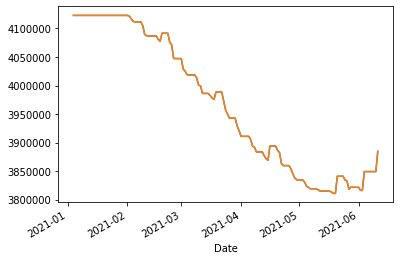

In [1165]:
# portfolio.share_flow()
# portfolio.shares()

# portfolio.cash_flow()
portfolio.cash().sum(axis=1).plot()
portfolio.cash().ffill().sum(axis=1).plot()

# portfolio.daily_returns(group_by=None)#.plot()

In [1166]:
portfolio.market_returns()#.plot()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.057143            0.000000   
2021-01-06                      -0.283784            0.000000   
2021-01-07                       0.354717            0.000000   
2021-01-08                       0.086351            0.070175   
...                                   ...                 ...   
2021-06-07                       0.000000            0.000000   
2021-06-08                       0.000000            0.000000   
2021-06-09                       0.000000            0.000000   
2021-06-10                       0.000000            0.000000   
2021-06-11                       0.000000            0.000000   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.060433            0.063158   
2021-01-06                      -0.225806           -0.229137   
2021-01-07                       0.270833            0.284404   
2021-01-08                      

In [1169]:
portfolio.active_returns()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                      

In [1170]:
portfolio[contracts].cumulative_returns()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-03-05   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210305C00136000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.067754           -0.061446   
2021-06-08                      -0.067754           -0.061446   
2021-06-09                      -0.067754           -0.061446   
2021-06-10                      -0.067754           -0.061446   
2021-06-11                      -0.067754           -0.061446   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00140000 AAPL210305C00150000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.040182           -0.068927   
2021-06-08                      -0.040182           -0.068927   
2021-06-09                      -0.040182           -0.068927   
2021-06-10                      -0.040182           -0.068927   
2021-06-11                      -0.040182           -0.068927   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                  2021-03-19   
oc_hx_contract_symbol AAPL210305C00160000 AAPL210319C00130000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.068635           -0.167916   
2021-06-08                      -0.068635           -0.167916   
2021-06-09                      -0.068635           -0.167916   
2021-06-10                      -0.068635           -0.167916   
2021-06-11                      -0.068635           -0.167916   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210319C00135000 AAPL210319C00140000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                      

In [1171]:
portfolio[contracts].returns_stats(group_by=None)

Start                    2021-01-04 00:00:00
End                      2021-06-11 00:00:00
Duration                   111 days 00:00:00
Total Return [%]                    -6.19347
Benchmark Return [%]                -58.8332
Annual Return [%]                   -4.29438
Annual Volatility [%]                24.4598
Sharpe Ratio                        -1.91987
Calmar Ratio                       -0.667883
Max. Drawdown [%]                   -14.0603
Omega Ratio                         0.599925
Sortino Ratio                       -1.89193
Skew                                 -1.4022
Kurtosis                             29.5981
Tail Ratio                               inf
Common Sense Ratio                       inf
Value at Risk                     -0.0108122
Alpha                              -0.120047
Beta                               0.0312395
Name: <lambda>, dtype: object

In [1172]:
portfolio[contracts].value_at_risk()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.000035
                                 2021-03-05         AAPL210305C00136000     -0.005227
                                                    AAPL210305C00140000     -0.003865
                                                    AAPL210305C00150000     -0.004995
                                                    AAPL210305C00160000     -0.004640
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00060000      -0.020105
                                                    XOM210416C00065000      -0.013562
                                                    XOM210416C00070000      -0.014555
                         YCBD    2021-02-19         YCBD210219C00007500      0.000000
                         ZM      2021-05-21         ZM210521C00400

In [1173]:
portfolio.total_market_return()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.997143
                                 2021-02-26         AAPL210226C00135000     -0.998246
                                 2021-03-05         AAPL210305C00136000     -0.998750
                                                    AAPL210305C00140000     -0.998400
                                                    AAPL210305C00150000     -0.997455
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00070000      -0.913043
                         YCBD    2021-02-19         YCBD210219C00007500     -0.700000
                         ZM      2021-04-30         ZM210430C00340000       -0.999111
                                 2021-05-21         ZM210521C00360000       -0.999099
                                                    ZM210521C00400

In [922]:
portfolio.total_profit().sort_values()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         CCL     2021-05-21         CCL210521C00030000      -12204.123
                                 2021-04-16         CCL210416C00030000       -9143.346
                                 2021-03-19         CCL210319C00030000       -7308.613
                                 2021-04-16         CCL210416C00035000       -7250.849
                                 2021-04-01         CCL210401C00030000       -6487.889
                                                                               ...    
                                 2021-03-19         CCL210319C00025000        9174.638
                                 2021-02-19         CCL210219C00021500       10291.906
                                 2021-02-26         CCL210226C00022000       13541.381
                                 2021-02-19         CCL210219C00022000       15056.237
                                                    CCL2

In [1174]:
# portfolio[contracts].get_drawdowns().plot()
# portfolio[contracts].max_drawdown(group_by=False)
# portfolio.drawdown()

cidx = 5
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
# portfolio.get_drawdowns(group_by='symbol').plot().show()

In [1175]:
# portfolio.value().vbt.plot()

In [1176]:
portfolio.total_return(group_by=False)

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.067754
                                 2021-02-26         AAPL210226C00135000      0.000000
                                 2021-03-05         AAPL210305C00136000     -0.061446
                                                    AAPL210305C00140000     -0.040182
                                                    AAPL210305C00150000     -0.068927
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00070000      -0.066001
                         YCBD    2021-02-19         YCBD210219C00007500     -0.058102
                         ZM      2021-04-30         ZM210430C00340000        0.000000
                                 2021-05-21         ZM210521C00360000        0.000000
                                                    ZM210521C00400

### Figure out how to extract trade details

In [1178]:
trade_df = portfolio.logs.records
trade_df[trade_df['order_id'] != -1].head()

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
26,26,26,0,0,inf,0.0,0.78,inf,600.0,0,...,True,inf,600.0,600.0,0.78,0.468,0,0,-1,0
32,32,32,0,0,inf,600.0,0.01,inf,-600.0,0,...,True,inf,0.0,600.0,0.01,0.006,1,0,-1,1
243,243,21,2,2,inf,0.0,4.20,inf,100.0,0,...,True,inf,100.0,100.0,4.20,0.420,0,0,-1,2
264,264,42,2,2,inf,100.0,0.01,inf,-100.0,0,...,True,inf,0.0,100.0,0.01,0.001,1,0,-1,3
354,354,21,3,3,inf,0.0,2.75,inf,100.0,0,...,True,inf,100.0,100.0,2.75,0.275,0,0,-1,4


In [1179]:
symbol = 'MVIS' #'CCL210521C00030000'#'AAL210521C00025000' MVIS
cidx = [i for i,c in enumerate(contracts) if symbol in c][0]
contracts[cidx]

('expiration', 'CALL', 'MVIS', '2021-02-19', 'MVIS210219C00016000')

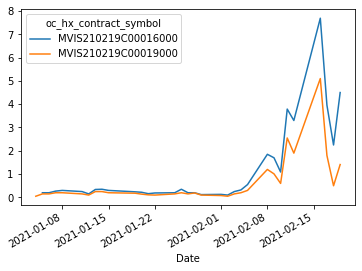

In [1180]:
df_tmp.loc[:,idx[contracts[cidx][1:4]]].plot()

In [1181]:
df_tmp.loc[:,idx[contracts[cidx][1:4]]]['AAL210219C00017000'].plot()
df_tmp.loc[:,idx[contracts[cidx][1:4]]]['AAL210219C00018000'].plot()

KeyError: 'AAL210219C00017000'

In [1182]:
portfolio[contracts[cidx][:4]].total_profit().reset_index().sort_values(by=[0],ascending=False)

,oc_hx_contract_symbol,0
0,MVIS210219C00016000,6262.770
1,MVIS210219C00019000,3020.975


In [1185]:
# portfolio.trades.records
# portfolio.orders.records
# portfolio[contracts[cidx][:4]].value()['AAL210219C00017000'].plot()
# portfolio[contracts[cidx][:4]].value()['AAL210219C00017500'].plot()
portfolio[contracts[cidx][:4]].value()['MVIS210219C00016000'].dropna()#.plot()

Date
2021-01-04     500.50
2021-01-05     500.50
2021-01-06     500.50
2021-01-07     500.50
2021-01-08     500.50
               ...   
2021-06-07    6763.27
2021-06-08    6763.27
2021-06-09    6763.27
2021-06-10    6763.27
2021-06-11    6763.27
Name: MVIS210219C00016000, Length: 111, dtype: float64

In [1186]:
# portfolio['ORCL']
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].value().plot()
portfolio[contracts[cidx][:4]].value()#.loc["2021-02-03":"2021-02-26"]

oc_hx_contract_symbol,MVIS210219C00016000,MVIS210219C00019000
Date,,
2021-01-04,500.50,500.500
2021-01-05,500.50,500.500
2021-01-06,500.50,500.500
2021-01-07,500.50,500.500
2021-01-08,500.50,500.500
...,...,...
2021-06-07,6763.27,3521.475
2021-06-08,6763.27,3521.475
2021-06-09,6763.27,3521.475


In [1187]:
df_tmp[contracts[cidx][1:4]]#.loc["2021-02-03":"2021-02-26"]

oc_hx_contract_symbol,MVIS210219C00016000,MVIS210219C00019000
Date,,
2021-01-04,NaN,0.05
2021-01-05,0.20,0.15
2021-01-06,0.20,0.15
2021-01-07,0.27,0.20
2021-01-08,0.30,0.20
...,...,...
2021-06-07,NaN,NaN
2021-06-08,NaN,NaN
2021-06-09,NaN,NaN


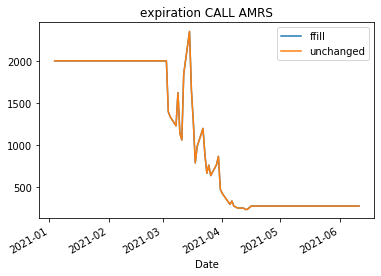

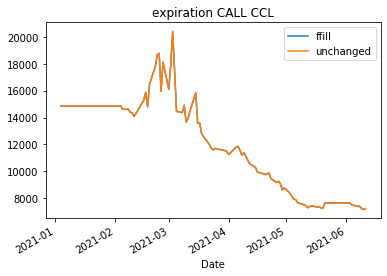

In [1188]:
# portfolio[('expiration','CALL','AMRS')].value()#['AMRS'].plot()
def plot_ffill_vs_unchanged_portfolio_value(portfolio,key='expiration',title=None):
    a = portfolio[key].value().ffill(axis=1).sum(axis=1)
    a.name = 'ffill'
    a.plot()
    b = portfolio[key].value().sum(axis=1)
    b.name = 'unchanged'
    b.plot(title=' '.join(key) if isinstance(key,tuple) else key)
    plt.legend()
    
plot_ffill_vs_unchanged_portfolio_value(portfolio,key=('expiration','CALL','AMRS'))
plt.figure()
plot_ffill_vs_unchanged_portfolio_value(portfolio,key=('expiration','CALL','CCL'))

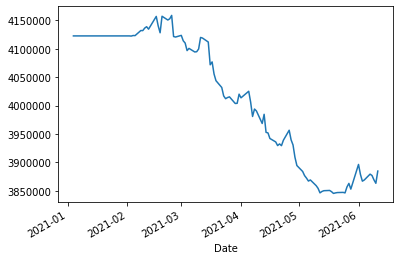

In [1190]:
portfolio['expiration'].value().sum(axis=1).plot()

In [1195]:
portfolio[('expiration','CALL','MVIS','2021-02-19','MVIS210219C00016000')].get_trades().records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,0,0,1500.0,22,0.32,0.48,32,4.5,6.75,6262.77,13.047438,0,1,0


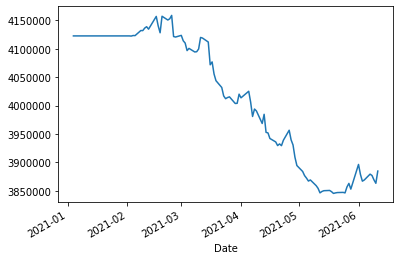

In [1201]:
# clearly need to figure this out, its not accounting for nans
portfolio.value().sum(axis=1).plot()
# portfolio.value(group_by='symbol').plot()

In [633]:
df[df['s_hx_symbol'] == 'ORCL']

contract_symbol  y_pred purch_date  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000               NaN     NaN        NaN   
           ORCL210219C00065000               NaN     NaN        NaN   
           ORCL210319C00070000               NaN     NaN        NaN   
           ORCL210319C00080000               NaN     NaN        NaN   
2021-01-05 ORCL210212C00064000               NaN     NaN        NaN   
...                                          ...     ...        ...   
2021-05-21 ORCL210521C00075000               NaN     NaN        NaN   
           ORCL210521C00077500               NaN     NaN        NaN   
           ORCL210521C00080000               NaN     NaN        NaN   
           ORCL210521C00082500               NaN     NaN        NaN   
           ORCL210521C00085000               NaN     NaN        NaN   

                                 purch_datetime  trade_price  \
oc_hx_date oc_hx_contract_symbol                               
2021-01-04 ORCL210212C00064000              NaN          NaN   
           ORCL210219C00065000              NaN          NaN   
           ORCL210319C00070000              NaN          NaN   
           ORCL210319C00080000              NaN          NaN   
2021-01-05 ORCL210212C00064000              NaN          NaN   
...                                         ...          ...   
2021-05-21 ORCL210521C00075000              NaN          NaN   
           ORCL210521C00077500              NaN          NaN   
           ORCL210521C00080000              NaN          NaN   
           ORCL210521C00082500              NaN          NaN   
           ORCL210521C00085000              NaN          NaN   

                                  open_day_after_purch  lo_day_after_purch  \
oc_hx_date oc_hx_contract_symbol                                             
2021-01-04 ORCL210212C00064000                     NaN                 NaN   
           ORCL210219C00065000                     NaN                 NaN   
           ORCL210319C00070000                     NaN                 NaN   
           ORCL210319C00080000                     NaN                 NaN   
2021-01-05 ORCL210212C00064000                     NaN                 NaN   
...                                                ...                 ...   
2021-05-21 ORCL210521C00075000                     NaN                 NaN   
           ORCL210521C00077500                     NaN                 NaN   
           ORCL210521C00080000                     NaN                 NaN   
           ORCL210521C00082500                     NaN                 NaN   
           ORCL210521C00085000                     NaN                 NaN   

                                  win  loss  close_day_of_exp  ...  oc_hx_hi  \
oc_hx_date oc_hx_contract_symbol                               ...             
2021-01-04 ORCL210212C00064000    NaN   NaN               NaN  ...      1.75   
           ORCL210219C00065000    NaN   NaN               NaN  ...      1.88   
           ORCL210319C00070000    NaN   NaN               NaN  ...      1.01   
           ORCL210319C00080000    NaN   NaN               NaN  ...      0.19   
2021-01-05 ORCL210212C00064000    NaN   NaN               NaN  ...      1.27   
...                               ...   ...               ...  ...       ...   
2021-05-21 ORCL210521C00075000    NaN   NaN               NaN  ...      4.75   
           ORCL210521C00077500    NaN   NaN               NaN  ...      2.35   
           ORCL210521C00080000    NaN   NaN               NaN  ...      0.22   
           ORCL210521C00082500    NaN   NaN               NaN  ...      0.03   
           ORCL210521C00085000    NaN   NaN               NaN  ...      0.01   

                                  oc_hx_lo  oc_hx_open  oc_hx_close  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000        1.63        1.75         1.63   
       

In [1199]:
# portfolio.plot(column='BTC-USD')
# portfolio.plot(index='BTC-USD')
portfolio.stats(group_by='symbol')

Start                            2021-01-04 00:00:00
End                              2021-06-11 00:00:00
Duration                           111 days 00:00:00
Init. Cash                                    136335
Total Profit                                -2310.79
Total Return [%]                            -1.69493
Benchmark Return [%]                         10.5696
Position Coverage [%]                        21.1635
Max. Drawdown [%]                            3.54824
Avg. Drawdown [%]                            1.99136
Max. Drawdown Duration              59 days 13:55:12
Avg. Drawdown Duration       32 days 23:18:07.200000
Num. Trades                                  5.46602
Win Rate [%]                                 10.8107
Best Trade [%]                               47.8419
Worst Trade [%]                              -35.493
Avg. Trade [%]                              -14.7573
Max. Trade Duration                 29 days 10:48:00
Avg. Trade Duration       24 days 16:37:33.445